# Exploring the solution object

Probabilistic IVP solvers are probabilistic numerical algorithms, which means they compute probability distributions over possible solutions instead of simple point estimates.
A probabilistic description is much richer than a non-probabilistic description, so the solution objects returned by the probabilistic IVP solver are worth investigating:

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax.config import config

from probdiffeq import dense_output, solution_routines, solvers
from probdiffeq.doc_util import notebook
from probdiffeq.implementations import recipes
from probdiffeq.strategies import smoothers

In [2]:
plt.rcParams.update(notebook.plot_config())

if not backend.has_been_selected:
    backend.select("jax")  # ivp examples in jax

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

In [3]:
# Make a problem
f, u0, (t0, t1), f_args = ivps.sir()


@jax.jit
def vector_field(y, *, t, p):
    return f(y, *p)


# Make a solver
solver = solvers.DynamicSolver(
    strategy=smoothers.Smoother(recipes.IsoTS0.from_params())
)

In [4]:
%%time
solution = solution_routines.solve_with_python_while_loop(
    vector_field,
    initial_values=(u0,),
    t0=t0,
    t1=t1,
    solver=solver,
    parameters=f_args,
    atol=1e-1,
    rtol=1e-1,
)

CPU times: user 3.4 s, sys: 25.8 ms, total: 3.42 s
Wall time: 3.33 s


We can access elements of the solution.

In [5]:
print(len(solution))
print(solution[-1])

203
Solution(t=200.0,u=[5.92689422e+01 7.86935530e-03 9.40723188e+02],output_scale_sqrtm=2.408267475584918,marginals=IsoStateSpaceVar(hidden_state=IsoNormal(mean=[[ 5.92689422e+01  7.86935530e-03  9.40723188e+02]
 [ 8.63284474e-03  3.98230928e-02 -4.84559375e-02]
 [ 2.49604419e-02  1.15140971e-01 -1.40101413e-01]
 [ 3.98257923e-02  1.83713882e-01 -2.23539674e-01]
 [ 2.87645009e-02  1.32688820e-01 -1.61453321e-01]], cov_sqrtm_lower=[[-1.6295078   0.          0.          0.          0.        ]
 [-0.00802873 -0.29278099  0.          0.          0.        ]
 [-0.02787631 -1.01581831 -0.10385692  0.          0.        ]
 [-0.05676967 -2.06767665 -0.66639318 -0.12523592  0.        ]
 [-0.05573158 -2.03564812 -1.5583179  -1.07064096 -0.55661733]])),posterior=MarkovSequence(init=IsoStateSpaceVar(hidden_state=IsoNormal(mean=[[ 5.92689422e+01  7.86935530e-03  9.40723188e+02]
 [ 8.63284474e-03  3.98230928e-02 -4.84559375e-02]
 [ 2.49604419e-02  1.15140971e-01 -1.40101413e-01]
 [ 3.98257923e-02  

We can plot an estimate of the solution.

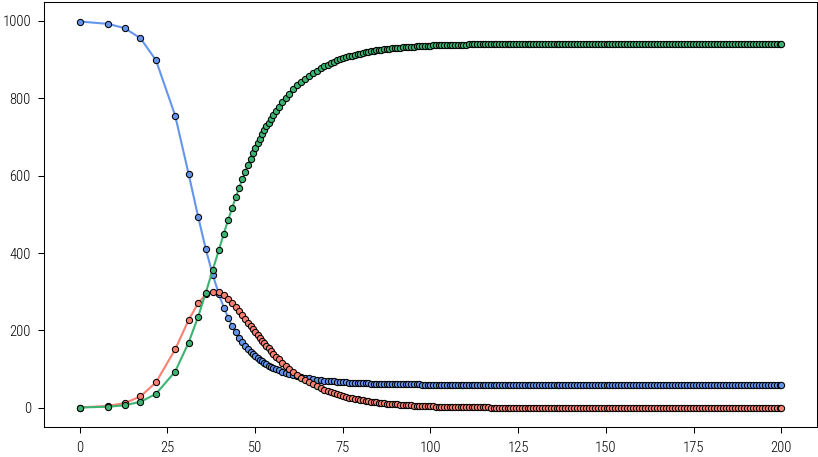

In [6]:
plt.plot(solution.t, solution.u, ".-")
plt.show()

But we can also look at the underlying distribution.
For starters, maybe we want to compute the marginal distribution over the solution away from
the grid points. This is similar to dense output, but, arguably, way cooler: there is not _one_ way of dense output with probabilistic solvers, but there many ways:

* marginals on off-grid points (most similar to traditional dense output)
* joint distributions on grid points and away from the grid points
* joint samples from the posterior

and many more options.

Check this out:

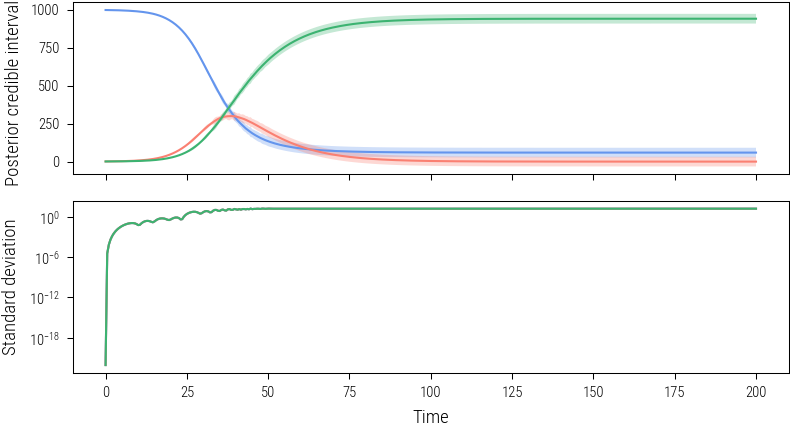

In [7]:
ts = jnp.linspace(t0 + 1e-4, t1 - 1e-3, num=400, endpoint=True)
_, dense = dense_output.offgrid_marginals_searchsorted(
    ts=ts, solution=solution, solver=solver
)

fig, ax = plt.subplots(nrows=2, sharex=True, tight_layout=True)

for i in [0, 1, 2]:  # ["S", "I", "R"]
    ms = dense.hidden_state.mean[:, 0, i]
    ls = dense.hidden_state.cov_sqrtm_lower[:, 0]

    # Exaggerate the uncertainty (for plotting reasons)
    stds = 10 * jnp.sqrt(jnp.einsum("jn,jn->j", ls, ls))

    ax[0].plot(ts, ms, marker="None")
    ax[0].fill_between(ts, ms - 1.96 * stds, ms + 1.96 * stds, alpha=0.3)
    ax[0].set_ylabel("Posterior credible intervals")

    ax[1].semilogy(ts, stds, marker="None")
    ax[1].set_ylabel("Standard deviation")

ax[1].set_xlabel("Time")
plt.show()

Stay tuned for more.